In [2]:
%matplotlib inline

from io import StringIO
import numpy as np
import pandas as pd
import scipy as sp
import pymc3 as pm
import matplotlib.pyplot as plt
from matplotlib.cm import Set2, Blues

plt.style.use('seaborn-whitegrid')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index().drop('level_0', axis=1)
    merged = pd.merge(
        df, source_data[group_columns],
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )


In [4]:
data = pd.read_csv('../data/Kline.csv', sep=';')

data = data.assign(
    high_contact = (data.contact == 'high').astype('int'),
    log_pop = np.log(data.population)
)

n_cultures = data.shape[0]

data

,culture,population,contact,total_tools,mean_TU,high_contact,log_pop
0,Malekula,1100,low,13,3.2,0,7.003065
1,Tikopia,1500,low,22,4.7,0,7.313220
2,Santa Cruz,3600,low,24,4.0,0,8.188689
3,Yap,4791,high,43,5.0,1,8.474494
4,Lau Fiji,7400,high,33,5.0,1,8.909235
5,Trobriand,8000,high,19,4.0,1,8.987197
6,Chuuk,9200,high,40,3.8,1,9.126959
7,Manus,13000,low,28,6.6,0,9.472705
8,Tonga,17500,high,55,5.4,1,9.769956
9,Hawaii,275000,low,71,6.6,0,12.524526


In [5]:
distances = (
"""Malekula,0.0,0.5,0.6,4.4,1.2,2.0,3.2,2.8,1.9,5.7
Tikopia,0.5,0.0,0.3,4.2,1.2,2.0,2.9,2.7,2.0,5.3
Santa Cruz,0.6,0.3,0.0,3.9,1.6,1.7,2.6,2.4,2.3,5.4
Yap,4.4,4.2,3.9,0.0,5.4,2.5,1.6,1.6,6.1,7.2
Lau Fiji,1.2,1.2,1.6,5.4,0.0,3.2,4.0,3.9,0.8,4.9
Trobriand,2.0,2.0,1.7,2.5,3.2,0.0,1.8,0.8,3.9,6.7
Chuuk,3.2,2.9,2.6,1.6,4.0,1.8,0.0,1.2,4.8,5.8
Manus,2.8,2.7,2.4,1.6,3.9,0.8,1.2,0.0,4.6,6.7
Tonga,1.9,2.0,2.3,6.1,0.8,3.9,4.8,4.6,0.0,5.0
Hawaii,5.7,5.3,5.4,7.2,4.9,6.7,5.8,6.7,5.0,0.0""")

distances = pd.read_csv(StringIO(distances), header=None)
distances.columns = ['island'] + list(distances[0].values)
distances = distances.set_index('island')
distances

,Malekula,Tikopia,Santa Cruz,Yap,Lau Fiji,Trobriand,Chuuk,Manus,Tonga,Hawaii
island,,,,,,,,,,
Malekula,0.0,0.5,0.6,4.4,1.2,2.0,3.2,2.8,1.9,5.7
Tikopia,0.5,0.0,0.3,4.2,1.2,2.0,2.9,2.7,2.0,5.3
Santa Cruz,0.6,0.3,0.0,3.9,1.6,1.7,2.6,2.4,2.3,5.4
Yap,4.4,4.2,3.9,0.0,5.4,2.5,1.6,1.6,6.1,7.2
Lau Fiji,1.2,1.2,1.6,5.4,0.0,3.2,4.0,3.9,0.8,4.9
Trobriand,2.0,2.0,1.7,2.5,3.2,0.0,1.8,0.8,3.9,6.7
Chuuk,3.2,2.9,2.6,1.6,4.0,1.8,0.0,1.2,4.8,5.8
Manus,2.8,2.7,2.4,1.6,3.9,0.8,1.2,0.0,4.6,6.7
Tonga,1.9,2.0,2.3,6.1,0.8,3.9,4.8,4.6,0.0,5.0


In [13]:
with pm.Model() as m_varying_intercepts:
    a = pm.Normal('a', mu=0, sd=1)
    b_pop = pm.Normal('b_pop', mu=0, sd=1)
    soc_bar = pm.Exponential('soc_bar', lam=1)

    soc_a = pm.Normal('soc_a', mu=0, sd=soc_bar,
                      shape=n_cultures)

    tools_i = pm.Deterministic(
        'tools_i',
        pm.math.exp(
            np.log(data.total_tools.mean())
            + a
            + soc_a[data.index.values]
            + b_pop * (data.log_pop.values - data.log_pop.values.mean())
        )
    )

    obs = pm.Poisson('obs', mu=tools_i,
                     observed=data.total_tools.values)

    m_varying_intercepts.name = 'varying intercepts'
    m_varying_intercepts.trace = pm.sample(2000, tune=1500, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [soc_a, soc_bar, b_pop, a]
Sampling 2 chains: 100%|██████████| 7000/7000 [00:09<00:00, 764.39draws/s]


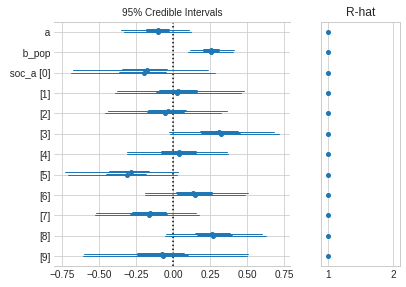

In [15]:
pm.forestplot(m_varying_intercepts.trace, varnames=['a', 'b_pop', 'soc_a'])
None

In [17]:
with pm.Model() as m_distance_ac:
    a = pm.Normal('a', mu=0, sd=1)
    b_pop = pm.Normal('b_pop', mu=0, sd=1)

    eta2 = pm.Exponential('eta2', lam=1)
    rho2 = pm.Exponential('rho2', lam=1)

    soc_cov = pm.Deterministic(
        'soc_cov',
        eta2 * pm.math.exp(-rho2 * np.square(distances.values)  / 12. )
        + np.diag(0.01 * np.ones(n_cultures))
    )
    soc_a = pm.MvNormal('soc_a', mu=0, cov=soc_cov, shape=n_cultures)

    tools_i = pm.Deterministic(
        'tools_i',
        pm.math.exp(
            np.log(data.total_tools.mean())
            + a
            + soc_a[data.index.values]
            + b_pop * (data.log_pop.values - data.log_pop.values.mean())
        )
    )

    obs = pm.Poisson('obs', tools_i,
                     observed=data.total_tools.values)

    m_distance_ac.name = 'distance autocorrelation'
    m_distance_ac.trace = pm.sample(2000, tune=2000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [soc_a, rho2, eta2, b_pop, a]
Sampling 2 chains: 100%|██████████| 8000/8000 [01:11<00:00, 111.76draws/s]
There were 721 divergences after tuning. Increase `target_accept` or reparameterize.
There were 446 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/pymc3/plots/forestplot.py:318: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/pymc3/plots/forestplot.py:319: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


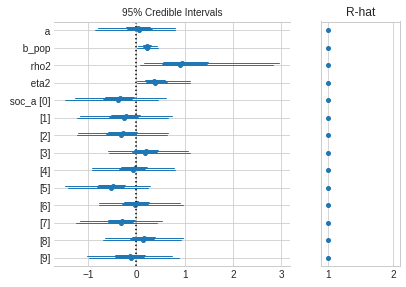

In [34]:
pm.forestplot(m_distance_ac.trace, varnames=['a', 'b_pop', 'rho2', 'eta2', 'soc_a'])
None

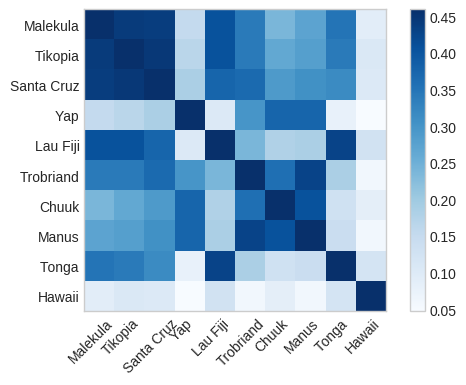

In [35]:
plt.figure(dpi=100)
plt.imshow(np.mean(m_distance_ac.trace['soc_cov'], axis=0),
           cmap=Blues,)
plt.gca().set(xticks=np.linspace(-.3, n_cultures-1.3, n_cultures),
              yticks=np.linspace(0, n_cultures-1, n_cultures),
              yticklabels=distances.index.values)
plt.gca().set_xticklabels(distances.index.values, rotation=45)
              
plt.grid(None)
plt.colorbar()

None

In [37]:
pm.compare({
    m_varying_intercepts: m_varying_intercepts.trace,
    m_distance_ac: m_distance_ac.trace,
})

/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
distance autocorrelation,66.43,3.58,0,1,2.41,0,1
varying intercepts,69.75,4.87,3.32,0,2.48,1.06,1
